In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomGrayscale(),
    transforms.RandomPerspective(),
    transforms.ToTensor()]) #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

batch_size = 64
block = 3 

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

torch.manual_seed(43)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=8,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [00:05, 30166900.95it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


images.shape: torch.Size([64, 3, 32, 32])


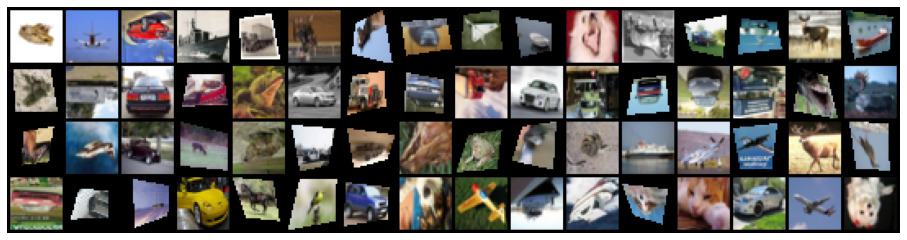

In [4]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

images.shape: torch.Size([64, 3, 32, 32])


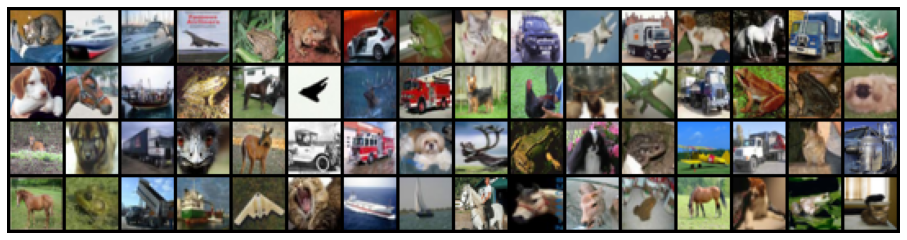

In [5]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # Set first filter  
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        
        # He initialization: 
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter 
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')
        
        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')
        self.dropout = nn.Dropout(0.2)
        #nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.pool = nn.MaxPool2d(2, 2)
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm1d(128)
        if block is 1:
          self.fc1 = nn.Linear(8192, 120)
          self.fc2 = nn.Linear(120, 10) # CHANGE 
          self.fc3 = nn.Linear(84, 10)
        else:  
          self.fc1 = nn.Linear(2048, 128)
          nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
          self.fc2 = nn.Linear(128, 10) # CHANGE 
          #self.fc3 = nn.Linear(400, 10)

    def forward(self, x):
        if block is 1:  
          # 1 VGG block: 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        else:
          # 3 VGG block 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = self.BN1(self.dropout(x))
          x = self.pool(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
          x = self.BN2(self.dropout(x))
          x = self.pool(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))
          x = self.BN3(self.dropout(x))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.BN4(self.dropout(x))
          x = self.fc2(x)
        
        

        #x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        #x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))

        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x


model = VGG() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu
## Loss and optimizer
learning_rate = 0.005 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= learning_rate,momentum=0.9) #Adam seems to be the most popular for deep learning
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
loss_store_train =[]
loss_store_val = []
acc_store=[]
epoches=100
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 0: 1.878
Got 3733 / 10000 with accuracy 37.33
Loss in epoch 1: 1.609
Got 4582 / 10000 with accuracy 45.82
Loss in epoch 2: 1.491
Got 5235 / 10000 with accuracy 52.35
Loss in epoch 3: 1.399
Got 4790 / 10000 with accuracy 47.90
Loss in epoch 4: 1.320
Got 5495 / 10000 with accuracy 54.95
Loss in epoch 5: 1.259
Got 5971 / 10000 with accuracy 59.71
Loss in epoch 6: 1.214
Got 6234 / 10000 with accuracy 62.34
Loss in epoch 7: 1.174
Got 6198 / 10000 with accuracy 61.98
Loss in epoch 8: 1.155
Got 6548 / 10000 with accuracy 65.48
Loss in epoch 9: 1.107
Got 6311 / 10000 with accuracy 63.11
Loss in epoch 10: 1.082
Got 6976 / 10000 with accuracy 69.76
Loss in epoch 11: 1.057
Got 6789 / 10000 with accuracy 67.89
Loss in epoch 12: 1.038
Got 6914 / 10000 with accuracy 69.14
Loss in epoch 13: 1.020
Got 7138 / 10000 with accuracy 71.38
Loss in epoch 14: 0.999
Got 6905 / 10000 with accuracy 69.05
Loss in epoch 15: 0.991
Got 7013 / 10000 with accuracy 70.13
Loss in epoch 16: 0.973
Got 7330 /

In [8]:
optimizer = optim.SGD(model.parameters(), lr= 0.01,momentum=0.9)
epoches=100
for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch+99}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 99: 0.672
Got 8125 / 10000 with accuracy 81.25
Loss in epoch 100: 0.673
Got 8143 / 10000 with accuracy 81.43
Loss in epoch 101: 0.671
Got 8190 / 10000 with accuracy 81.90
Loss in epoch 102: 0.674
Got 8172 / 10000 with accuracy 81.72
Loss in epoch 103: 0.666
Got 8256 / 10000 with accuracy 82.56
Loss in epoch 104: 0.659
Got 8267 / 10000 with accuracy 82.67
Loss in epoch 105: 0.663
Got 8239 / 10000 with accuracy 82.39
Loss in epoch 106: 0.654
Got 8251 / 10000 with accuracy 82.51
Loss in epoch 107: 0.655
Got 8193 / 10000 with accuracy 81.93
Loss in epoch 108: 0.650
Got 8307 / 10000 with accuracy 83.07
Loss in epoch 109: 0.654
Got 8349 / 10000 with accuracy 83.49
Loss in epoch 110: 0.645
Got 8315 / 10000 with accuracy 83.15
Loss in epoch 111: 0.641
Got 8382 / 10000 with accuracy 83.82
Loss in epoch 112: 0.640
Got 8346 / 10000 with accuracy 83.46
Loss in epoch 113: 0.633
Got 8348 / 10000 with accuracy 83.48
Loss in epoch 114: 0.644
Got 8273 / 10000 with accuracy 82.73
Loss in e

In [9]:
optimizer = optim.SGD(model.parameters(), lr= 0.005,momentum=0.9)
epoches=120
for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch+150}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 150: 0.560
Got 8600 / 10000 with accuracy 86.00
Loss in epoch 151: 0.556
Got 8564 / 10000 with accuracy 85.64
Loss in epoch 152: 0.547
Got 8602 / 10000 with accuracy 86.02
Loss in epoch 153: 0.540
Got 8598 / 10000 with accuracy 85.98
Loss in epoch 154: 0.543
Got 8595 / 10000 with accuracy 85.95
Loss in epoch 155: 0.542
Got 8629 / 10000 with accuracy 86.29
Loss in epoch 156: 0.542
Got 8608 / 10000 with accuracy 86.08
Loss in epoch 157: 0.543
Got 8603 / 10000 with accuracy 86.03
Loss in epoch 158: 0.537
Got 8598 / 10000 with accuracy 85.98
Loss in epoch 159: 0.539
Got 8610 / 10000 with accuracy 86.10
Loss in epoch 160: 0.543
Got 8616 / 10000 with accuracy 86.16
Loss in epoch 161: 0.539
Got 8610 / 10000 with accuracy 86.10
Loss in epoch 162: 0.532
Got 8648 / 10000 with accuracy 86.48
Loss in epoch 163: 0.537
Got 8625 / 10000 with accuracy 86.25
Loss in epoch 164: 0.534
Got 8622 / 10000 with accuracy 86.22
Loss in epoch 165: 0.532
Got 8656 / 10000 with accuracy 86.56
Loss in 

In [10]:
optimizer = optim.SGD(model.parameters(), lr= 0.005,momentum=0.9)
epoches=100
for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch+270}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 270: 0.491
Got 8748 / 10000 with accuracy 87.48
Loss in epoch 271: 0.487
Got 8703 / 10000 with accuracy 87.03
Loss in epoch 272: 0.481
Got 8682 / 10000 with accuracy 86.82
Loss in epoch 273: 0.478
Got 8711 / 10000 with accuracy 87.11
Loss in epoch 274: 0.486
Got 8732 / 10000 with accuracy 87.32
Loss in epoch 275: 0.485
Got 8756 / 10000 with accuracy 87.56
Loss in epoch 276: 0.485
Got 8740 / 10000 with accuracy 87.40
Loss in epoch 277: 0.488
Got 8722 / 10000 with accuracy 87.22
Loss in epoch 278: 0.481
Got 8708 / 10000 with accuracy 87.08
Loss in epoch 279: 0.482
Got 8778 / 10000 with accuracy 87.78
Loss in epoch 280: 0.483
Got 8769 / 10000 with accuracy 87.69
Loss in epoch 281: 0.481
Got 8755 / 10000 with accuracy 87.55
Loss in epoch 282: 0.486
Got 8694 / 10000 with accuracy 86.94
Loss in epoch 283: 0.486
Got 8690 / 10000 with accuracy 86.90
Loss in epoch 284: 0.478
Got 8771 / 10000 with accuracy 87.71
Loss in epoch 285: 0.481
Got 8734 / 10000 with accuracy 87.34
Loss in 

Text(0, 0.5, 'Accuracy')

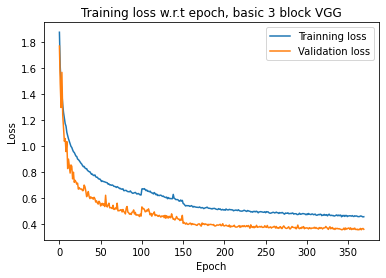

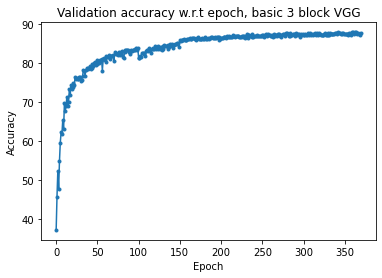

In [12]:

plt.figure(1)
plt.plot(loss_store_train,label = 'Trainning loss')
plt.plot(loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, basic 3 block VGG') 
plt.figure(2)
plt.plot(acc_store,marker='.')
plt.title('Validation accuracy w.r.t epoch, basic 3 block VGG') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [13]:
PATH = './multiple.pth'
torch.save(model.state_dict(), PATH)

In [19]:
net = VGG()
net.load_state_dict(torch.load(PATH))


with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(test_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

Got 8783 / 10000 with accuracy 87.83
